# Infering Shannon Diversity Index
In this exercise we will obtain the Shannon's diversity index for the Mexican Territory using the GBIF dataset and the Taxonomic Structure stored in the *Biospytial Graph Engine* .

The result will be a probability density function with a visualization of the prediction (conditional distribution given covariates).

The steps to follow are:

1.- Load the libraries and modules and init environments.

In [2]:
%matplotlib inline
import sys
sys.path.append('/apps')
import django
django.setup()
from drivers.tree_builder import TreeNeo
from drivers.graph_models import TreeNode, Order, Family, graph,Kingdom,Occurrence
from drivers.graph_models import Cell,Mex4km, countObjectsOf
from drivers.graph_models import pickNode
import matplotlib.pyplot as plt
import pandas as pd
import itertools as it
import numpy as np

## Use the ggplot style
plt.style.use('ggplot')

2. Selecting the space of considered cells.
For this case we will consider all the Mexican Territory. We can load the Mexican polygon from the database with the following commands.

> Failing to do so will likely obtain all the registered cells. In cases could hang the system.

In [4]:
from sketches.models import Country
from mesh.models import MexMesh
from traversals.sampling import UniformRandomCellSample

Mexico = Country.objects.filter(name__contains="exico").get()
mexican_cells = MexMesh.objects.filter(cell__intersects=Mexico.geom)

In [106]:
# Get all cell ids
ids = list(mexican_cells.values('pk'))
CellNodeClass = Mex4km
list_of_cell_ids = ids
sample_size = 301
selection_of_cells = UniformRandomCellSample(ids,Mex4km,sample_size=sample_size,random_seed=12345,with_replacement=True)

INFO Using custom random seed of: 12345
INFO Compiling Query and asking the Graph Database


The size of 'ids' is {{n}}
3. Generate the trees for each cell.


In [107]:
%time cells = list(selection_of_cells)

CPU times: user 1.92 s, sys: 92 ms, total: 2.01 s
Wall time: 11.3 s


In [12]:
c = cells[0]

1.2 We will use the function *buildTreeNeo* to extract the taxonomic tree in that area.

In [17]:
from traversals import strategies as st
%time trees = map(lambda cell : st.buildTreeNeo(cell),cells)

CPU times: user 42.2 s, sys: 1.16 s, total: 43.4 s
Wall time: 52 s


The histogram of count occurences here will be:


In [25]:
nc = pd.DataFrame({'c':map(lambda c : c.richness, 
                   trees)})

In [65]:
new = nc.loc[(nc.c < 40) & (nc.c > 0)]

(array([19., 17.,  6.,  7.,  3.,  4.,  4.,  3.,  5.,  4.,  6.,  4.,  2.,
         1.,  3.,  1.,  2.,  3.,  2.,  0.,  0.,  2.,  1.,  0.,  1.,  0.,
         1.,  1.,  0.,  0.,  1.,  0.,  3.,  0.,  0.,  0.,  1.,  2.,  0.,
         1.]),
 array([ 1.  ,  1.95,  2.9 ,  3.85,  4.8 ,  5.75,  6.7 ,  7.65,  8.6 ,
         9.55, 10.5 , 11.45, 12.4 , 13.35, 14.3 , 15.25, 16.2 , 17.15,
        18.1 , 19.05, 20.  , 20.95, 21.9 , 22.85, 23.8 , 24.75, 25.7 ,
        26.65, 27.6 , 28.55, 29.5 , 30.45, 31.4 , 32.35, 33.3 , 34.25,
        35.2 , 36.15, 37.1 , 38.05, 39.  ]),
 <a list of 40 Patch objects>)

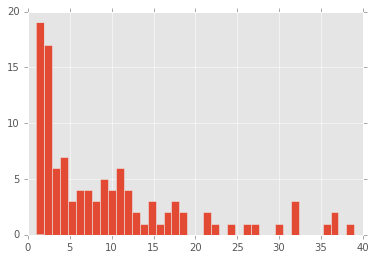

In [66]:
plt.hist(new.c,bins=40)

## Calculate big Tree


In [71]:
%time ocs = reduce(lambda a,b : a + b ,map(lambda t : t.occurrences, trees))

CPU times: user 4 ms, sys: 8 ms, total: 12 ms
Wall time: 12.7 ms


In [73]:
## Ohh! super fast (compared to the other method that takes more than 20 minutes for this sample size)
%time bigtree = TreeNeo(ocs,cell_objects=cells)

CPU times: user 448 ms, sys: 24 ms, total: 472 ms
Wall time: 450 ms


In [87]:
reptiles = t.to_Animalia.to_Chordata.to_Reptilia

In [104]:
## Get presences absences
pres_reps = pd.DataFrame(map(lambda tree : if tree.hasNode(reptiles): 1,trees))


SyntaxError: invalid syntax (<ipython-input-104-249a33f5e241>, line 2)

In [103]:
%time data = st.getEnvironmentalCovariatesFromListOfCells(cells)

CPU times: user 4.35 s, sys: 112 ms, total: 4.46 s
Wall time: 1min 44s


In [105]:
data

,Elevation_mean,MaxTemperature_mean,MeanTemperature_mean,MinTemperature_mean,Precipitation_mean,SolarRadiation_mean,Vapor_mean,WindSpeed_mean,Longitude,Latitude
0,63.222222,30.225231,20.7662,30.3171,7.560185,18867.312500,1.75,2.26389,-113.380563,27.54339
1,3.888889,27.693981,23.0694,27.8079,58.791667,16915.250000,2.21296,4.41667,-97.406563,25.68139
2,2353.000000,21.844722,13.7833,21.8806,47.480556,18051.152778,1,3.11389,-103.629563,22.83939
3,1305.777778,27.772222,20.794,27.831,85.865741,18112.976852,1.30093,2.18519,-107.255563,25.97539
4,1212.777778,26.811343,N.A.,N.A.,19.287037,19742.972222,N.A.,N.A.,-107.500563,31.80639
5,283.444444,30.418518,23.6551,30.5046,57.622685,17391.502315,1.97454,2.2338,-98.974563,24.35839
6,59.555556,29.541945,23.2556,29.4611,55.769444,17422.047222,2.33333,2.90833,-97.994563,24.16239
7,108.555556,32.506019,24.4306,32.4977,48.060185,18315.770833,1.5,2.08333,-108.676563,26.46539
8,2240.333333,22.721111,13.3722,22.7694,43.850000,18295.166667,0.513889,3.53333,-106.667563,29.06239
9,174.111111,28.574537,21.2847,28.6412,8.601852,19137.398148,1.6088,3,-114.409563,29.69939
